In [30]:
%load_ext autoreload
%autoreload 2
import sys
import os
import pandas as pd
import numpy as np 
from pathlib import Path
from hypnose_analysis.utils.metrics_utils import *
from hypnose_analysis.utils.visualization_utils import *
from hypnose_analysis.utils.movement_analysis_utils import *
#from utils.visualization_utils import _load_tracking_and_behavior
import harp
from ipywidgets import widgets
from IPython.display import display
import moviepy
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Metrics Visualization

In [ ]:
subjid = 40
dates = (20251118, 20251231)

In [ ]:
# Plots response times for completes trials vs early choice trials as boxplots
fig, ax = plot_response_times_completed_vs_fa(subjid, dates=dates, y_limit=5000)

In [ ]:
# Per odor plots bias if FA are for port A or B
figs = plot_fa_ratio_a_over_sessions(subjid, dates=dates)

In [ ]:
# Plots Early Choice and Abortion rates as boxplots across sessions for each position and odor. Can set what FA types to include and whether to include non-initiated trials in FA. 
fig, axes = plot_abortion_and_fa_rates(subjid, dates=dates, include_noninitiated_in_fa_odor=False, fa_types='FA_time_in') #can use one or more FA Type filter, or 'All'. E.g., use 'FA_time_in,FA_time_out'

In [ ]:
# Plots if FAs are more often to reward port A or B for each odor, if FA is at that odor, one position after, or anywhere after. 
# Can filter by FA types: 'FA_time_in', 'FA_time_out', 'FA_late', or combinations like 'FA_time_in,FA_time_out'
# Can also exclude FAs at a specific position with exclude_last_pos=True (by default set to pos5, can be changed with last_odor_num=x)
fig, axes = plot_fa_ratio_by_hr_position(subjid, dates=dates, fa_types='FA_time_in', print_statistics=True, exclude_last_pos=True, debug=False)


In [ ]:
# Plot FA Ratio by Abortion Odor (comparing HR vs No HR trials)
# Shows FA distribution across aborted sequences grouped by the odor where abortion occurred
fig, axes = plot_fa_ratio_by_abort_odor(subjid, dates=dates, fa_types='FA_time_in')


In [ ]:
# Plots boxplots of every sampling time across all sessions, sepearated by position and odor. For completed trials and aborted trials. 
fig, axes = plot_sampling_times_analysis(40, dates=(20251125, 20251231))

In [ ]:
# Plot decision accuracy, with option to plot accuracy for A and B and global choice accuracy. 
fig, ax = plot_decision_accuracy_by_odor(40, dates=(20251125, 20251231), plot_choice_acc=False, plot_AB=True, clean_graph=False)

In [ ]:
figs = plot_behavior_metrics(
    subjids=[40],
    dates=(20251125, 20251231),
    variables=[
        "hidden_rule_detection_rate",
    ],
    protocol_filter=None,
    compute_if_missing=False, 
    verbose=True, 
    black_white=True, 
    y_range=(0, 1.1), 
    plot_HR_separately=True, 
    clean_graph=True, 
)

# 2. Behavior / Movement analysis

In [ ]:
# Plot cumulative rewards for multiple sessions and subjects. Can be split by days or consecutive. 
plot_cumulative_rewards(subjids=[40], dates=(20251125, 20251231), split_days=True)

In [ ]:
# Plots all choices for one or more sessions
choice_plots = plot_choice_history(subjid=40, dates=[20251203])

Loaded SLEAP tracking: 243541 frames from sub-040_ses-20251211_combined_sleap_tracking_timestamps.csv


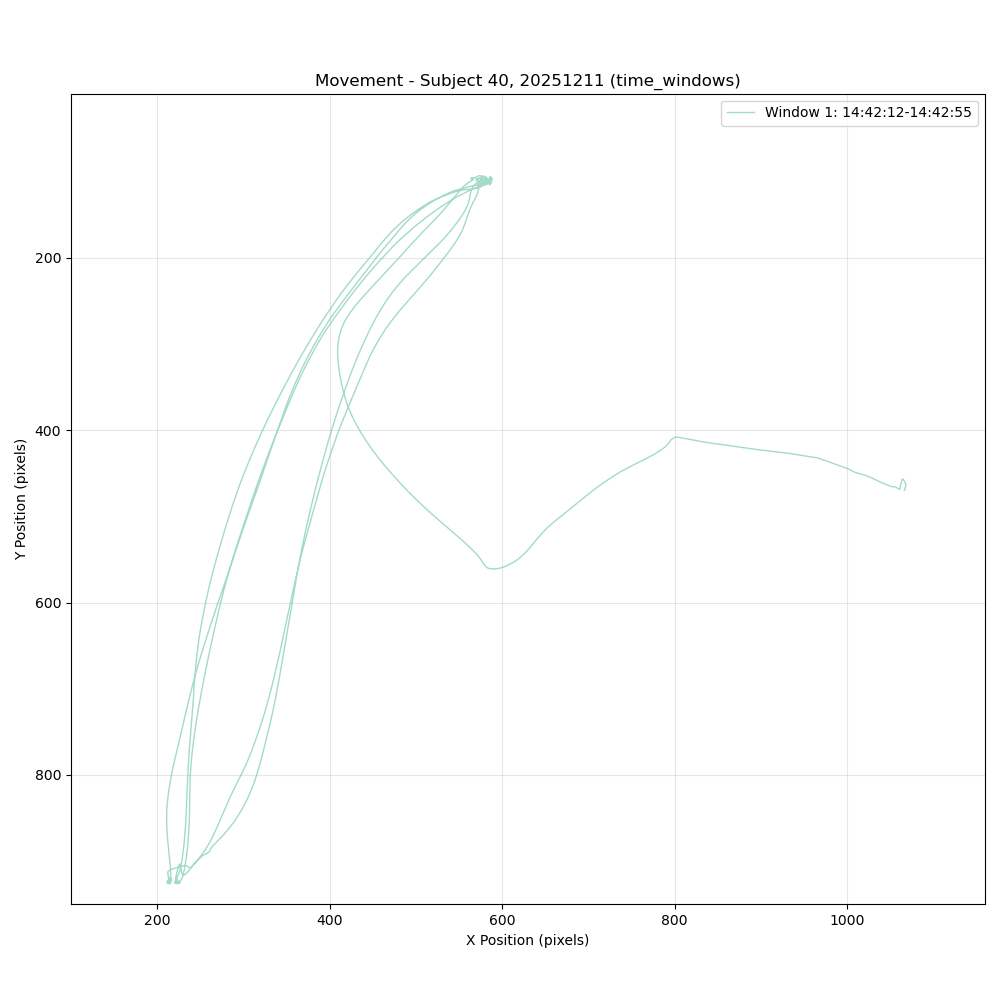

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Movement - Subject 40, 20251211 (time_windows)'}, xlabel='X Position (pixels)', ylabel='Y Position (pixels)'>)

In [24]:
# modes can be simple (all movement), trial_state (within trial vs outside), last_odor (A vs B), trial_windows (one or more trial windows), time_windows (one or more time windows), or trial_windows_rew
# for trial_windows: trial_windows=[(0, 20), (-20, None)] will plot first vs last 20 trials
# for time_windows: time_windows=[("15:20:00","15:25:00"), ("16:00:00","16:05:00")] will plot 2 5-minute windows
plot_movement_with_behavior(40, 20251211, mode='time_windows', time_windows=[("14:42:12", "14:42:55")],trial_windows=[(0, 10), (-10,None)], xlim=(100,1160), ylim=(10,950))


## Plot movement traces for different modes - plot_trial_trace_by_mode quick guide

- Common args: subjid, dates (list [] or range ()), xlim, ylim, smooth_window (frames), linewidth, alpha, invert_y
- Modes: 
    - rewarded: rewarded trials only
    - rewarded_hr: rewarded trials; HR trials colored with HR palette
    - completed: all completed trials (rewarded, unrewarded, timeout)
    - all_trials: completed and aborted trials
    - fa_by_response: FA trials (selected by fa_types filter), sorted by response port
    - fa_by_odor: FA trials, sorted by each aborted odor
    - hr_only: hidden-rule trials, colored by associated reward port, with rewarded and unrewarded trials
- Options: 
    - show_average: adds mean trace + SEM per category
    - highlight_hr: in rewarded/all_trials mode, recolor HR trials in different palette
    - color_by_index: ignore categories; color each trace by normalized sample index
    - fa_types: filter FA labels (select between "FA_time_in", "FA_time_out", or both)

In [ ]:
plot_trial_traces_by_mode(
    subjid=40,
    dates=[20251231],
    mode='completed',
    xlim=(100,1160),
    ylim=(10,950),
    show_average=False, 
    highlight_hr=True, 
    color_by_index=False,
    color_by_speed=True,
    fa_types=['FA_time_in'],
    figsize=(10,6)
)

# Modes: 
    # rewarded, rewarded_hr, completed, all_trials, fa_by_response, fa_by_odor, hr_only

# Speed Analysis

[CACHE HIT] SLEAP session for subjid=40, date=20251211


C:\Users\HarrisLab\Desktop\Repos\hypnose\hypnose-analysis\src\hypnose_analysis\utils\movement_analysis_utils.py:437: RuntimeWarning: Mean of empty slice
  print(f"Plot saved to {save_path}")
C:\Users\HarrisLab\Desktop\Repos\hypnose\hypnose-analysis\src\hypnose_analysis\utils\movement_analysis_utils.py:452: RuntimeWarning: Mean of empty slice
  last_odor_colors=None,        # {'A':'red','B':'blue','other':'gray'}


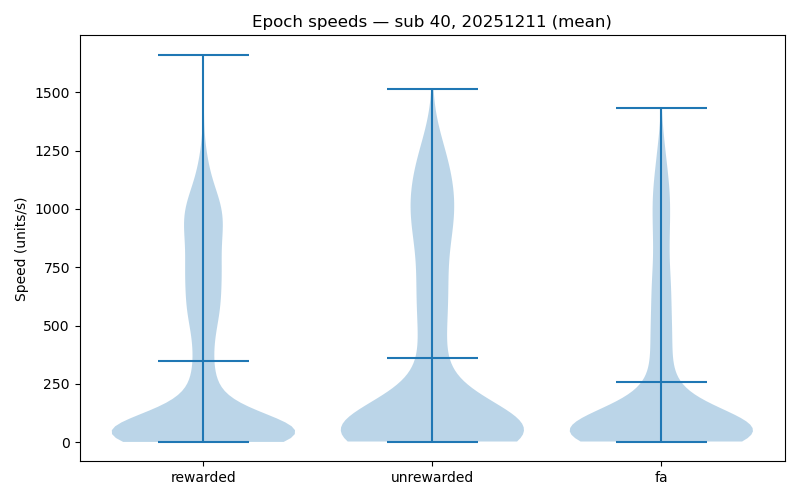

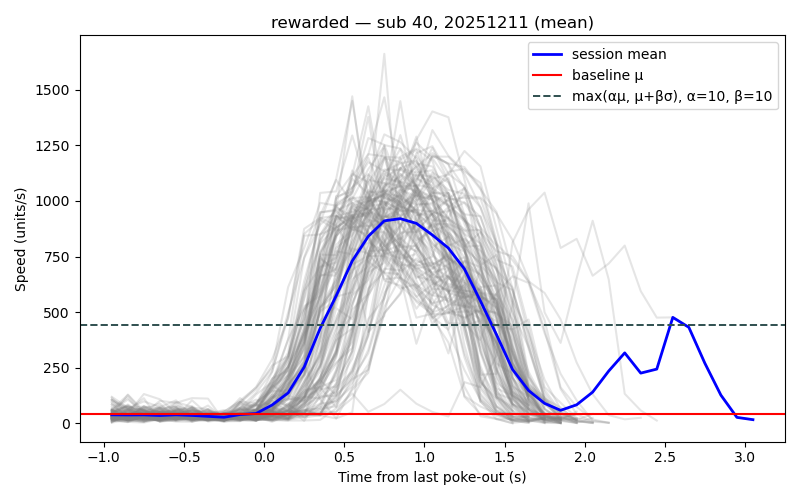

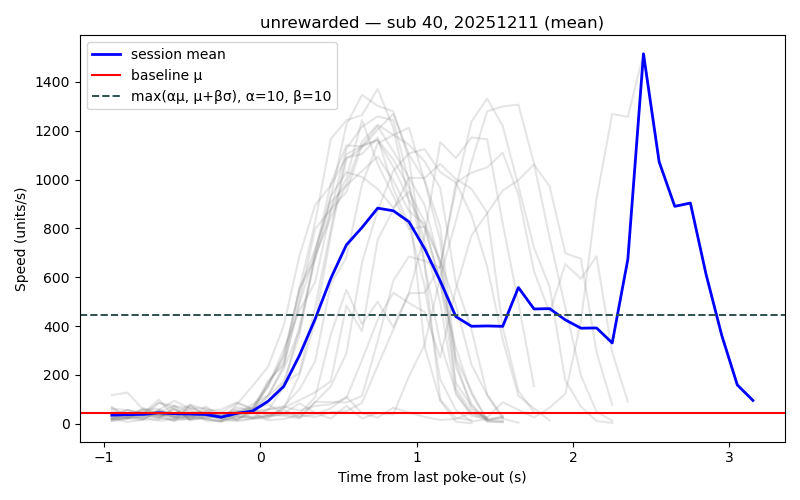

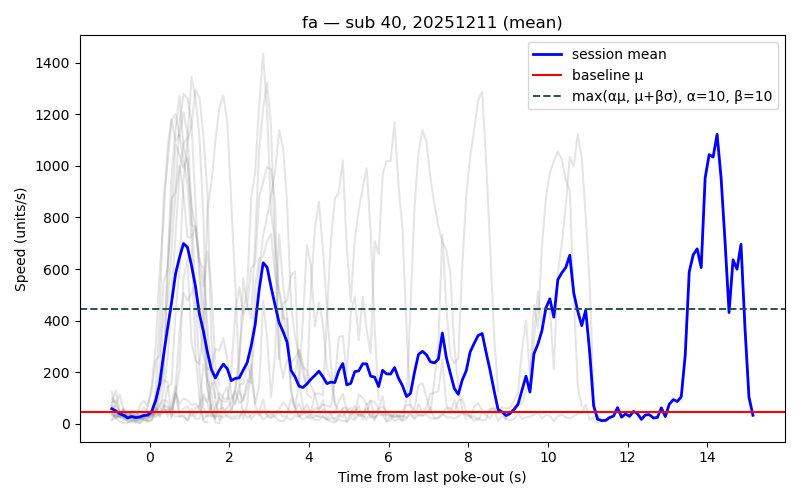

In [29]:
speed_analysis = plot_epoch_speeds_by_condition(
    subjid=40,
    dates=[20251211],
    bin_ms=100,
    pre_buffer_s=1,
    fa_label_filter=["fa_time_in", "fa_time_out"],
    mode="mean", # max or mean
    threshold=True,
    threshold_alpha=10.0,
    threshold_beta=10.0,
)

[CACHE HIT] SLEAP session for subjid=40, date=20251211


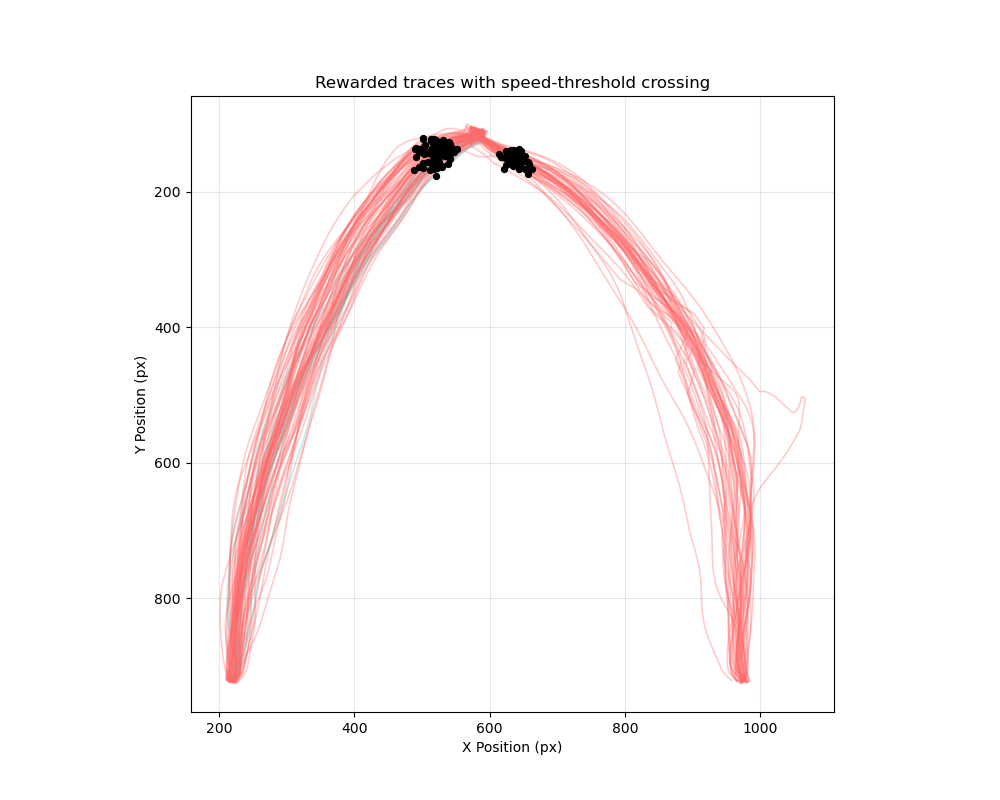

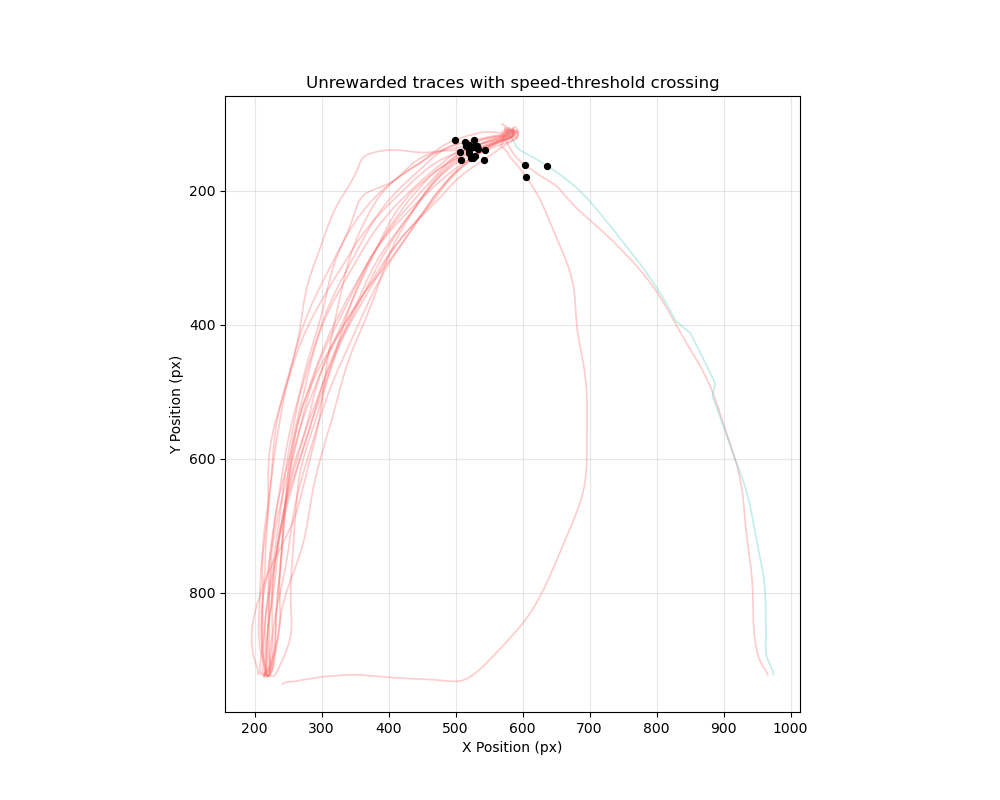

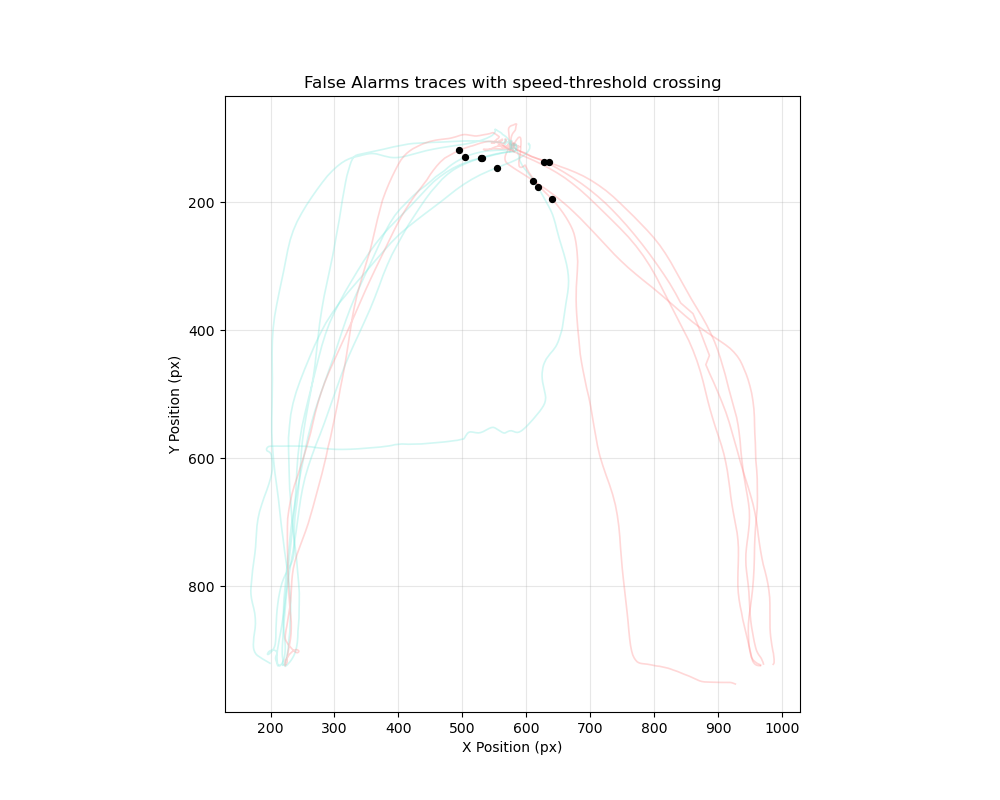

In [24]:
fig_thresh = plot_traces_with_speed_threshold(
    subjid=40,
    dates=[20251211],
    fa_types=["FA_time_in"],
    pre_buffer_s=0.5,
    threshold_alpha=70.0,
    threshold_beta=70.0,
    smooth_window=5,
    invert_y=True, 
)

[CACHE HIT] SLEAP session for subjid=40, date=20251231


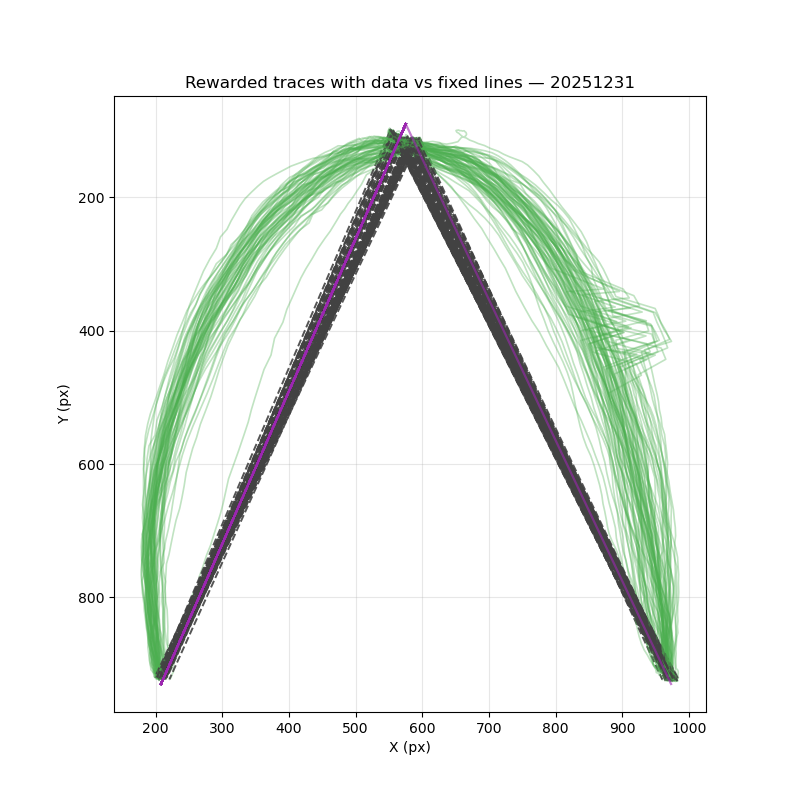

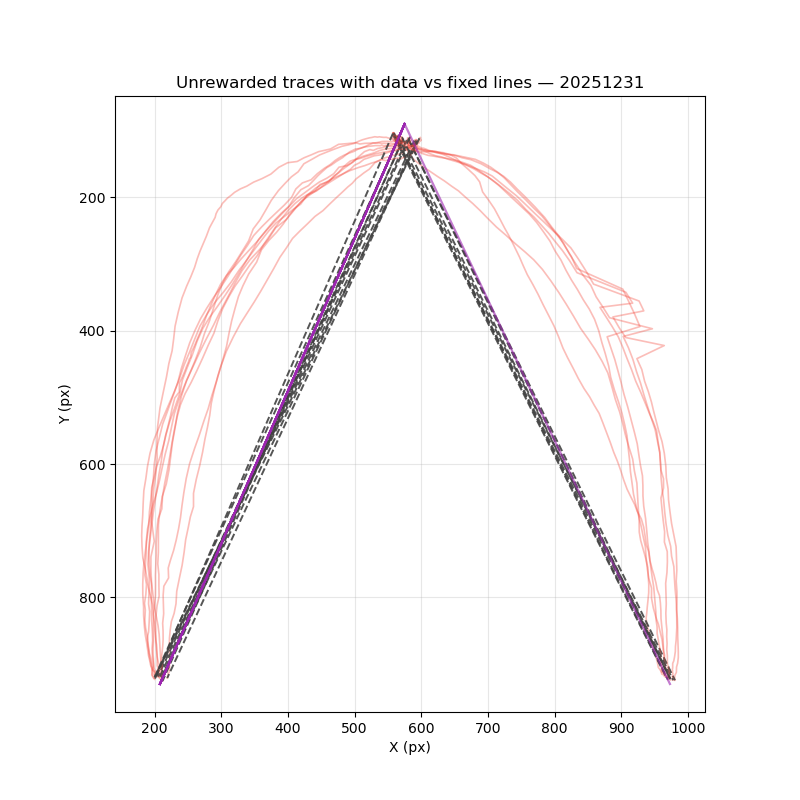

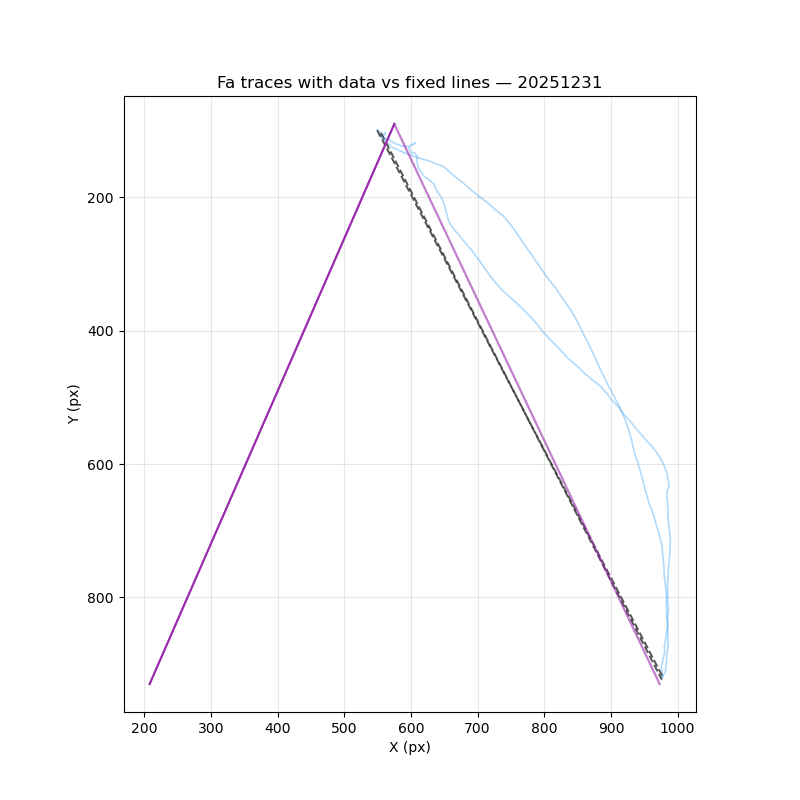

In [5]:
figs_overlay = plot_tortuosity_lines_overlay(
    subjid=40,
    dates=[20251231],
    fa_types=["FA_time_in"],
    bin_ms=100,
    fixed_start_xy=(575, 90),
    fixed_goal_a_xy=(208, 930),
    fixed_goal_b_xy=(973, 930),
)

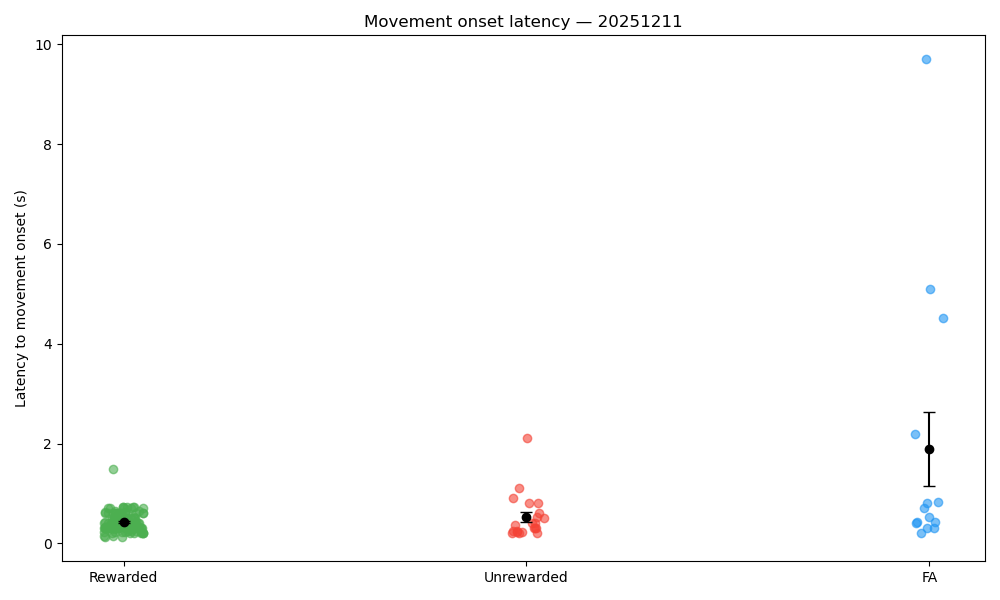

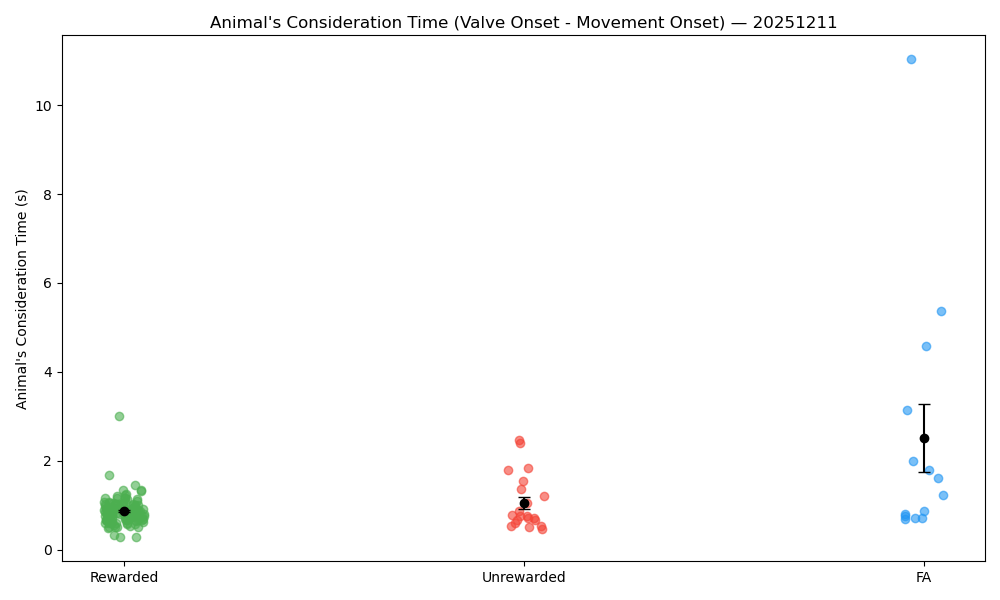

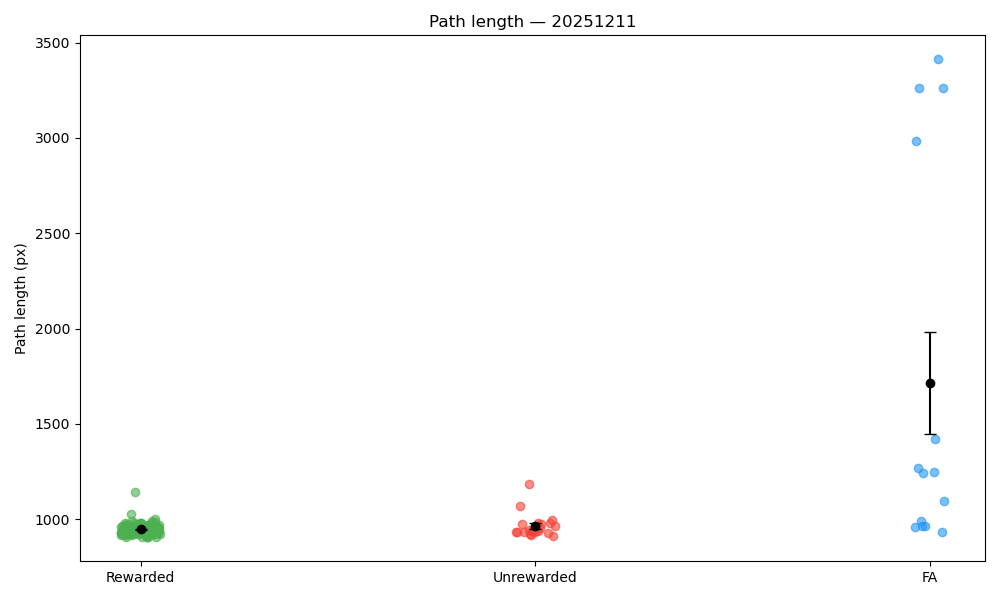

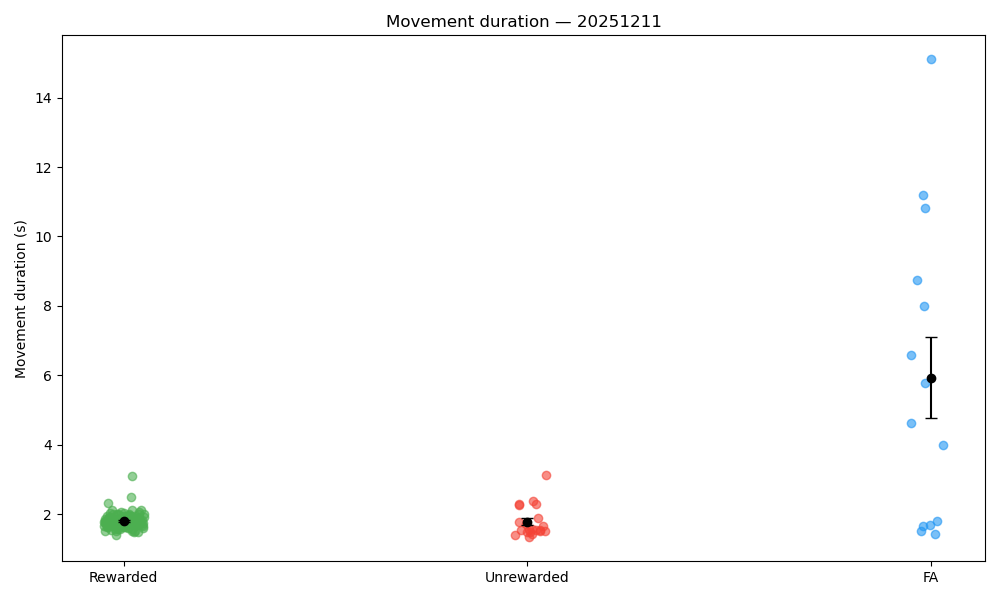

In [31]:
onset_latency = plot_movement_analysis_statistics(
    subjid=40,
    dates=[20251211],
    fa_types=["FA_time_in", "FA_time_out"],
)

In [14]:
plt.close('all')

In [15]:
print_cache_keys()

[CACHE CONTENTS] Current cache keys:
  (40, '20251231', 'sleap_session')
  (40, '20251231', 'speed_analysis')


# Debugging


In [23]:
from pathlib import Path
import pandas as pd
from hypnose_analysis.paths import get_derivatives_root

# Scan speed bins for high speeds in the pre-zero window (rewarded trials only)
subjid = 40
date = 20251211
speed_threshold = 250.0
t_min, t_max = -0.7, -0.15  # seconds relative to t=0

sub_str = f"sub-{subjid:03d}"
deriv_root = get_derivatives_root()
sub_dirs = list(deriv_root.glob(f"{sub_str}_id-*"))
if not sub_dirs:
    raise FileNotFoundError(f"No subject dir for {sub_str} under {deriv_root}")
sub_dir = sub_dirs[0]

ses_dirs = list(sub_dir.glob(f"ses-*_date-{date}"))
if not ses_dirs:
    raise FileNotFoundError(f"No session dir for date {date}")
ses_dir = ses_dirs[0]

results_dir = ses_dir / "saved_analysis_results"
analysis_path = results_dir / "speed_analysis.parquet"
trial_path_parquet = results_dir / "trial_data.parquet"
trial_path_csv = results_dir / "trial_data.csv"

if not analysis_path.exists():
    raise FileNotFoundError(f"speed_analysis.parquet not found at {analysis_path}")

df = pd.read_parquet(analysis_path)

# Optional: load trial metadata to report trial_id if available
trial_df = None
if trial_path_parquet.exists():
    trial_df = pd.read_parquet(trial_path_parquet)
elif trial_path_csv.exists():
    trial_df = pd.read_csv(trial_path_csv)

# Filter to rewarded trials
if "condition" in df.columns:
    df = df[df["condition"] == "rewarded"].copy()
rewarded_indices = None
if trial_df is not None and "response_time_category" in trial_df.columns:
    rewarded_mask = (trial_df["response_time_category"].str.lower() == "rewarded") & (~trial_df.get("is_aborted", False).astype(bool))
    rewarded_indices = set(trial_df.index[rewarded_mask].tolist())
    df = df[df["trial_index"].isin(rewarded_indices)]

# Apply window and speed filters
mask_window = df["bin_mid_s"].between(t_min, t_max, inclusive="both")
mask_speed = df["speed"] > speed_threshold
suspect = df[mask_window & mask_speed].copy()

if suspect.empty:
    print("No bins exceed threshold in the requested window (rewarded trials only).")
else:
    trial_counts = suspect.groupby("trial_index").size().sort_index()
    print(f"Found {len(suspect)} bins across {trial_counts.size} rewarded trials")
    print("Trial indices:", list(trial_counts.index))
    if trial_df is not None and "trial_id" in trial_df.columns:
        id_map = trial_df["trial_id"]
        labeled = [id_map.get(idx, idx) if hasattr(id_map, "get") else idx for idx in trial_counts.index]
        print("Trial IDs:", labeled)
    display(suspect.sort_values(["trial_index", "bin_mid_s"])[["trial_index", "bin_mid_s", "speed"]].head(30))

Found 18 bins across 5 rewarded trials
Trial indices: [22, 23, 36, 37, 48]
Trial IDs: [np.int64(22), np.int64(23), np.int64(36), np.int64(37), np.int64(48)]


,trial_index,bin_mid_s,speed
1301,22,-0.65,671.835688
1302,22,-0.55,1078.339092
1303,22,-0.45,1017.324543
1304,22,-0.35,1008.919497
1305,22,-0.25,1051.002904
1306,22,-0.15,930.731982
1338,23,-0.65,824.675188
1339,23,-0.55,808.550665
1340,23,-0.45,735.788927
1341,23,-0.35,737.275696


In [23]:
# Quick peek at first 20 trials: latency_s and movement_onset_from_valve_s
subjid = 40
date = 20251211
from pathlib import Path
import pandas as pd
from hypnose_analysis.paths import get_derivatives_root

# Locate speed_analysis.parquet
sub_str = f"sub-{subjid:03d}"
deriv_root = get_derivatives_root()
sub_dirs = list(deriv_root.glob(f"{sub_str}_id-*"))
if not sub_dirs:
    raise FileNotFoundError(f"No subject dir for {sub_str} under {deriv_root}")
sub_dir = sub_dirs[0]
ses_dirs = list(sub_dir.glob(f"ses-*_date-{date}"))
if not ses_dirs:
    raise FileNotFoundError(f"No session dir for date {date}")
ses_dir = ses_dirs[0]
results_dir = ses_dir / "saved_analysis_results"
analysis_path = results_dir / "speed_analysis.parquet"
if not analysis_path.exists():
    raise FileNotFoundError(f"speed_analysis.parquet not found at {analysis_path}")

# Load and show first 20 trials with the two latencies
df = pd.read_parquet(analysis_path)
cols = [c for c in ["trial_index", "trial_id", "latency_s", "movement_onset_from_valve_s"] if c in df.columns]
display(df[cols].drop_duplicates(subset="trial_index").sort_values("trial_index").head(20))

,trial_index,latency_s,movement_onset_from_valve_s
0,0,0.810976,1.059680
44,1,0.816096,1.799488
111,2,4.508480,4.582240
190,3,0.511040,0.512512
229,6,0.536933,1.236645
337,7,0.829290,0.859881
466,8,0.533504,1.840351
504,9,2.200384,3.142400
565,10,0.701216,1.999520
737,11,0.805152,2.469728


In [17]:
# Inspect trial 20 (global_trial_id = 20): last valve_start, last poke_odor_end, fa_time, and derived latencies
subjid = 40
date = 20251211
target_trial_id = 20
import pandas as pd
import json
from hypnose_analysis.paths import get_derivatives_root

deriv_root = get_derivatives_root()
sub_dir = next(iter(sorted(deriv_root.glob(f"sub-{subjid:03d}_id-*"))))
ses_dir = next(iter(sorted(sub_dir.glob(f"ses-*_date-{date}"))))
results_dir = ses_dir / "saved_analysis_results"
trial_csv = results_dir / "trial_data.csv"
trial_parquet = results_dir / "trial_data.parquet"

if trial_parquet.exists():
    trials = pd.read_parquet(trial_parquet)
elif trial_csv.exists():
    trials = pd.read_csv(trial_csv)
else:
    raise FileNotFoundError("trial_data not found (csv or parquet)")

# Locate row by global trial_id
if "trial_id" in trials.columns:
    row = trials[trials["trial_id"] == target_trial_id]
else:
    row = trials.iloc[[target_trial_id]] if target_trial_id < len(trials) else pd.DataFrame()
if row.empty:
    raise ValueError(f"Trial with trial_id={target_trial_id} not found")
row = row.iloc[0]

def _safe_dt(val):
    try:
        return pd.to_datetime(val)
    except Exception:
        return pd.NaT

def _parse_positions(val):
    if isinstance(val, str):
        try:
            val = json.loads(val)
        except Exception:
            return []
    entries = []
    if isinstance(val, dict) and val:
        vals = list(val.values())
        if all(isinstance(v, dict) and "position" in v for v in vals):
            vals = sorted(vals, key=lambda v: v.get("position", 0))
        entries = vals
    elif isinstance(val, list) and val:
        entries = [v for v in val if isinstance(v, dict)]
    return entries

pvt_entries = _parse_positions(row.get("position_valve_times"))
ppt_entries = _parse_positions(row.get("position_poke_times"))

last_valve = None
last_poke_end = None
if pvt_entries:
    for ent in reversed(pvt_entries):
        ts = _safe_dt(ent.get("valve_start"))
        if pd.notna(ts):
            last_valve = ts
            break
if ppt_entries:
    for ent in reversed(ppt_entries):
        ts = _safe_dt(ent.get("poke_odor_end"))
        if pd.notna(ts):
            last_poke_end = ts
            break

fa_time = _safe_dt(row.get("fa_time"))
latency_s = (fa_time - last_poke_end).total_seconds() if (pd.notna(fa_time) and pd.notna(last_poke_end)) else float("nan")
movement_from_valve_s = (fa_time - last_valve).total_seconds() if (pd.notna(fa_time) and pd.notna(last_valve)) else float("nan")

print(f"Trial trial_id={target_trial_id}")
print(f"Last valve_start: {last_valve}")
print(f"Last poke_odor_end: {last_poke_end}")
print(f"fa_time: {fa_time}")
print(f"latency_s (poke_end -> fa_time): {latency_s}")
print(f"movement_onset_from_valve_s (valve_start -> fa_time): {movement_from_valve_s}")

Trial trial_id=20
Last valve_start: 2025-12-11 14:42:02.049504
Last poke_odor_end: 2025-12-11 14:42:03.382592
fa_time: 2025-12-11 14:42:14.590720
latency_s (poke_end -> fa_time): 11.208128
movement_onset_from_valve_s (valve_start -> fa_time): 12.541216
